# Automated Model Discovery for Pure Single-Crystal Semiconductor/Dielectric Materials

Code by Brandon Ferraro
Code modeled after CANN notebook by Skyler St. Pierre & Kevin Linka \\


In [ ]:
!pip install matplotlib==3.2.2
!pip install tensorflow==2.12.0
!pip install numpy==1.23.5
!pip install pandas==1.5.3

**Select `Runtime` > `Restart Session` at the top of the file before running the next code block!**

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import custom_object_scope
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import json
import pandas as pd
import os
import copy
from sklearn.metrics import r2_score
from IPython.display import Image
from tensorflow.keras.layers import BatchNormalization

print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__)
print('Tensorflow: ' + tf.__version__)
print('Keras: ' + keras.__version__)
print('Pandas: ' + pd.__version__)

Numpy: 1.23.5
Matplotlib: 3.2.2
Tensorflow: 2.12.0
Keras: 2.12.0
Pandas: 1.5.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/ME233Final/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def makeDIR(path):
    if not os.path.exists(path):
        os.makedirs(path)

filename = 'ThermCondCANN'
path2saveRaw = path + 'Results/'+filename+'/RawData'
makeDIR(path2saveRaw)

### 1. Load k(T) datasets

In [ ]:
def getData(Material):

    if Material == 'Si':
        df = pd.read_csv(path + 'PureSiDataset.csv')
    elif Material == 'NaCl':
        df = pd.read_csv(path + 'PureNaClDataset.csv')
    elif Material == 'Diamond':
        df = pd.read_csv(path + 'PureType2aDiamondDataset.csv')
    elif Material == 'Ge':
        df = pd.read_csv(path + 'PureGeDataset.csv')

    T = df.iloc[:,0].dropna().astype(np.float64)
    k = df.iloc[:,1].dropna().astype(np.float64)

    return T, k

In [ ]:
Debye_Si = 645 # K
Debye_NaCl = 322 # K
Debye_Diamond = 2230 # K
Debye_Ge = 374 # K

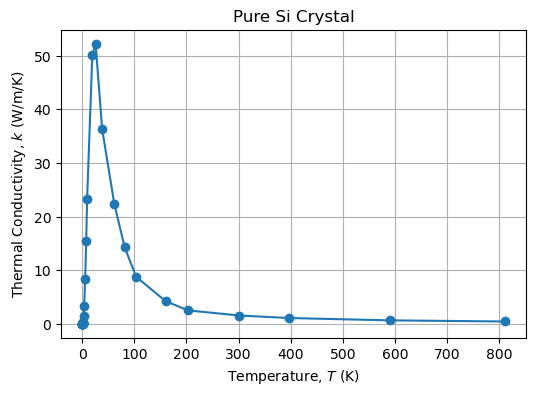

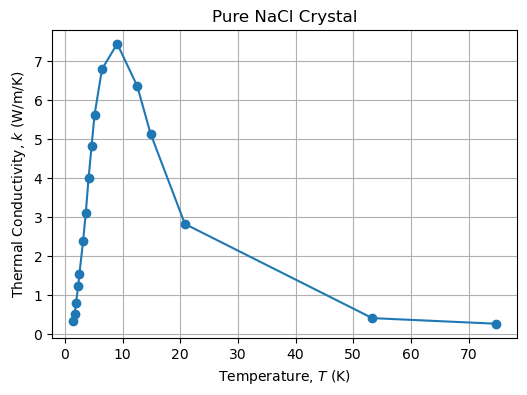

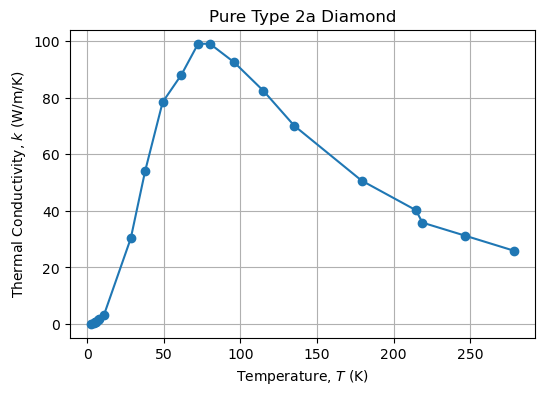

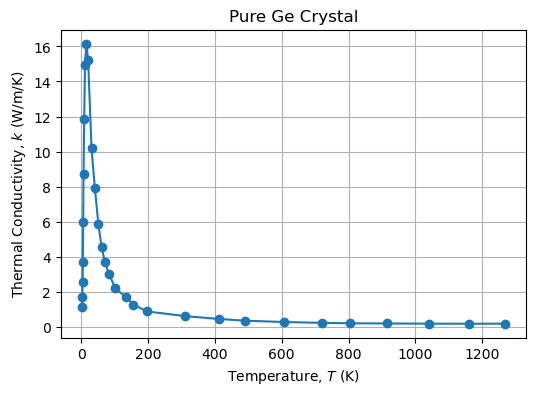

In [ ]:
materials = {'Si': 'Pure Si Crystal', 'NaCl': 'Pure NaCl Crystal', 'Diamond': 'Pure Type 2a Diamond', 'Ge': 'Pure Ge Crystal'}

for material, title in materials.items():
    T, k = getData(material)
    plt.figure(figsize=(6, 4))
    plt.plot(T, k, marker='o')
    plt.xlabel('Temperature, $T$ (K)')
    plt.ylabel('Thermal Conductivity, $k$ (W/m/K)')
    plt.title(title)
    plt.grid(True)
    plt.show()

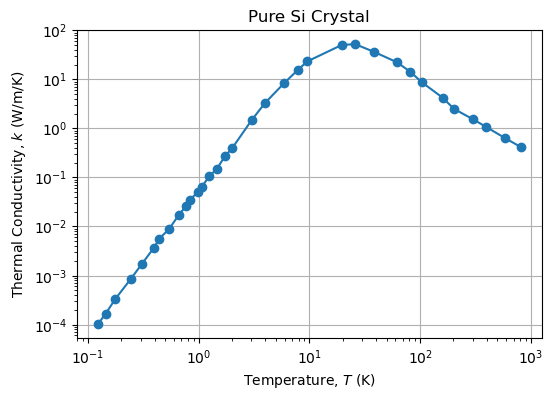

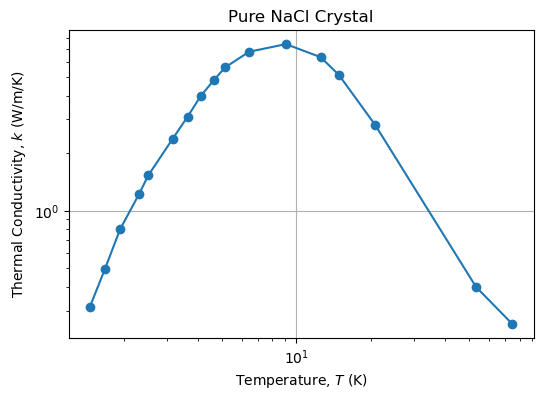

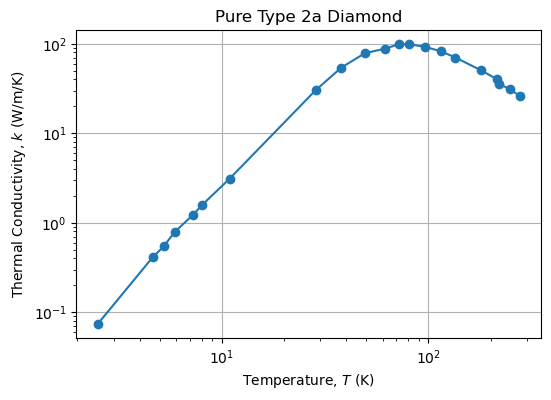

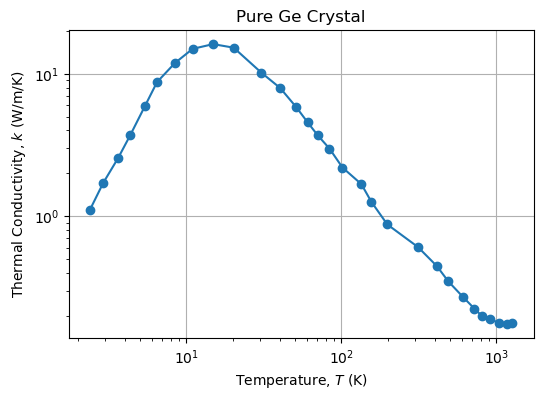

In [ ]:
materials = {'Si': 'Pure Si Crystal', 'NaCl': 'Pure NaCl Crystal', 'Diamond': 'Pure Type 2a Diamond', 'Ge': 'Pure Ge Crystal'}

for material, title in materials.items():
    T, k = getData(material)
    plt.figure(figsize=(6, 4))
    plt.loglog(T, k, marker='o')
    plt.xlabel('Temperature, $T$ (K)')
    plt.ylabel('Thermal Conductivity, $k$ (W/m/K)')
    plt.title(title)
    plt.grid(True)
    plt.show()

### Neural Network Architecture



In [ ]:
class SmoothHeaviside(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SmoothHeaviside, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_1_1 = self.add_weight(name='w_1_1', shape=(1,), initializer=tf.keras.initializers.Constant(10.0), trainable=True)
        self.w_1_2 = self.add_weight(name='w_1_2', shape=(1,), initializer=tf.keras.initializers.Constant(2.0), trainable=True)
        super(SmoothHeaviside, self).build(input_shape)

    def call(self, x):
        return tf.sigmoid(self.w_1_1 * ( x - self.w_1_2))

def ThermalConductivityCANN(pen):

    # Input Layer: log(T)
    logT = keras.layers.Input(shape=(1,), name='LogTemperature0')

    # First Hidden Layer
    identity1 = keras.layers.Lambda(lambda x: x, name="Identity1")(logT)
    heaviside1 = SmoothHeaviside(name="SmoothHeaviside1")(logT)
    h1_out = [identity1, heaviside1]

    # Second Hidden Layer (w_2,1 to w_2,8)
    h2_out = []
    for j, h in enumerate(h1_out):
        h2_out.extend([
            keras.layers.Lambda(lambda x: tf.math.exp(tf.clip_by_value(x, -100, 100)), name=f"Exp2_{j}")(h),
            keras.layers.Lambda(lambda x: x, name=f"Identity2_{j}")(h),
            keras.layers.Lambda(lambda x: tf.math.tanh(x), name=f"Tanh2_{j}")(h)
        ])

    # Bias term (w_2,9)
    h2_out.append(keras.layers.Lambda(lambda x: tf.ones_like(x), name="BiasTerm2")(h1_out[0]))

    h2_weighted = [keras.layers.Dense(1, use_bias=False, kernel_regularizer=keras.regularizers.l1(pen), name=f"Weight2_{i}")(h) for i, h in enumerate(h2_out)]

    # Output Layer: log(k)
    k_out = keras.layers.Add(name='LogThermalConductivity4')(h2_weighted)

    # Define and return the model
    model = keras.models.Model(inputs=[logT], outputs=[k_out], name='ThermalConductivityCANN')
    return model

### Compiling & Fitting

In [ ]:
def Compile_and_fit(model, logT, logk, epochs, path_checkpoint):

    mse_loss = keras.losses.MeanSquaredError()
    metrics  = keras.metrics.MeanSquaredError()
    opti1 = tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=5e-4,
            decay_steps=5000,
            decay_rate=0.95,
            staircase=True),
        clipnorm=0.5)

    model.compile(loss=mse_loss, optimizer=opti1, metrics=metrics)

    es_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=3000, restore_best_weights=True)
    modelckpt_callback = keras.callbacks.ModelCheckpoint(monitor="loss", filepath=path_checkpoint, verbose=0, save_weights_only=True, save_best_only=True)

    history = model.fit(logT, logk, batch_size=batch_size, epochs=epochs, callbacks=[es_callback, modelckpt_callback], shuffle = True, verbose = 0)

    return model, history

### Model Training

In [ ]:
from itertools import permutations
epochs = 10000
batch_size = 10
folder_name = 'ME233Results'

penalties = [0, 0.001, 0.01, 0.1]

path2saveResults_0 = path + 'Results/'+filename+'/'+folder_name
makeDIR(path2saveResults_0)

Model_summary = path2saveResults_0 + '/Model_summary.txt'

3.938391
3.987956
[-0.009653256, 1.3636996, 2.6461675, -2.095887, -0.92974955, 1.4883044, -0.8124101]
Si : R^2 =  0.9836470831650204  and Penalty =  0
4.452155
2.6474335
[-0.0834908, 1.896168, 0.95995164, -0.69294894, -1.2445968, -0.29194972, -1.2066646]
NaCl : R^2 =  0.980365352833209  and Penalty =  0
6.0648184
2.4754648
[-0.012465217, 1.0743995, -1.8159174, -0.53442806, 1.2859716, 3.7636964, -0.21628156]
Diamond : R^2 =  0.9672182303752689  and Penalty =  0
2.3930867
4.2582717
[-0.0020844385, 0.40970716, 3.0462093, -1.516473, -0.912403, -0.039466172, -0.24267922]
Ge : R^2 =  0.9580337389947161  and Penalty =  0
8.39091
1.5422496
[-0.015387305, 0.79343325, 3.2877753, -0.2969557, 0.3526389, 1.3911033, -2.7413614]
Si : R^2 =  0.9096736174726563  and Penalty =  0.001
5.6488147
2.7429066
[-0.075313374, 1.6742381, 1.0605776, -0.8010283, 0.17526163, -1.6817077, -0.9596075]
NaCl : R^2 =  0.9739791597041565  and Penalty =  0.001
6.8676248
2.4713466
[-0.008632669, 0.57620955, -0.22159728, -0.

<ipython-input-27-5cdaccc29a93>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_ind, ax_ind = plt.subplots(figsize=(6, 4))


4.087161
2.7256894
[-0.06864339, 1.3862381, 1.9800452, -0.9790223, -0.31295538, -0.37829554, -1.1542729]
NaCl : R^2 =  0.9876121253279703  and Penalty =  0.01


<ipython-input-27-5cdaccc29a93>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_loss, ax_loss = plt.subplots(figsize=[6, 5])
<ipython-input-27-5cdaccc29a93>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_ind, ax_ind = plt.subplots(figsize=(6, 4))


7.9839926
3.269553
[-0.018767592, 1.8005161, -0.35875115, -1.1451329, 2.7477508, 0.97241735, -1.8632604]
Diamond : R^2 =  0.9864027295387948  and Penalty =  0.01


<ipython-input-27-5cdaccc29a93>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_loss, ax_loss = plt.subplots(figsize=[6, 5])
<ipython-input-27-5cdaccc29a93>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_ind, ax_ind = plt.subplots(figsize=(6, 4))


2.3679953
4.3752766
[-0.00283498, 0.6241668, 1.1451842, -0.71525997, -0.75973296, -2.5921397, 0.27451783]
Ge : R^2 =  0.9491650537025926  and Penalty =  0.01


<ipython-input-27-5cdaccc29a93>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_loss, ax_loss = plt.subplots(figsize=[6, 5])
<ipython-input-27-5cdaccc29a93>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_ind, ax_ind = plt.subplots(figsize=(6, 4))


2.9267383
3.6932554
[-0.013270931, 2.173186, 1.0472237, -2.9271991, -0.00039185645, -0.00036807818, -0.00028296877]
Si : R^2 =  0.9789077560590671  and Penalty =  0.1


<ipython-input-27-5cdaccc29a93>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_loss, ax_loss = plt.subplots(figsize=[6, 5])
<ipython-input-27-5cdaccc29a93>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_ind, ax_ind = plt.subplots(figsize=(6, 4))


7.48918
2.6672232
[-0.08459983, 1.5745789, 6.283211e-05, -0.7843097, -6.437348e-05, -8.787034e-05, 5.1908566e-05]
NaCl : R^2 =  0.90359307620626  and Penalty =  0.1


<ipython-input-27-5cdaccc29a93>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_loss, ax_loss = plt.subplots(figsize=[6, 5])
<ipython-input-27-5cdaccc29a93>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_ind, ax_ind = plt.subplots(figsize=(6, 4))


6.4517975
4.8974442
[0.00044721842, 1.7461718, -0.05655928, -1.8974596, -0.00018016114, 0.00032887526, -1.0589571]
Diamond : R^2 =  0.9604484755647411  and Penalty =  0.1


<ipython-input-27-5cdaccc29a93>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_loss, ax_loss = plt.subplots(figsize=[6, 5])
<ipython-input-27-5cdaccc29a93>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_ind, ax_ind = plt.subplots(figsize=(6, 4))


6.4598985
1.555003
[-0.0016656881, -0.57725424, 0.0016634325, 1.3958949, 0.0019473392, 0.002368369, 0.0015813163]
Ge : R^2 =  0.9350793665941033  and Penalty =  0.1


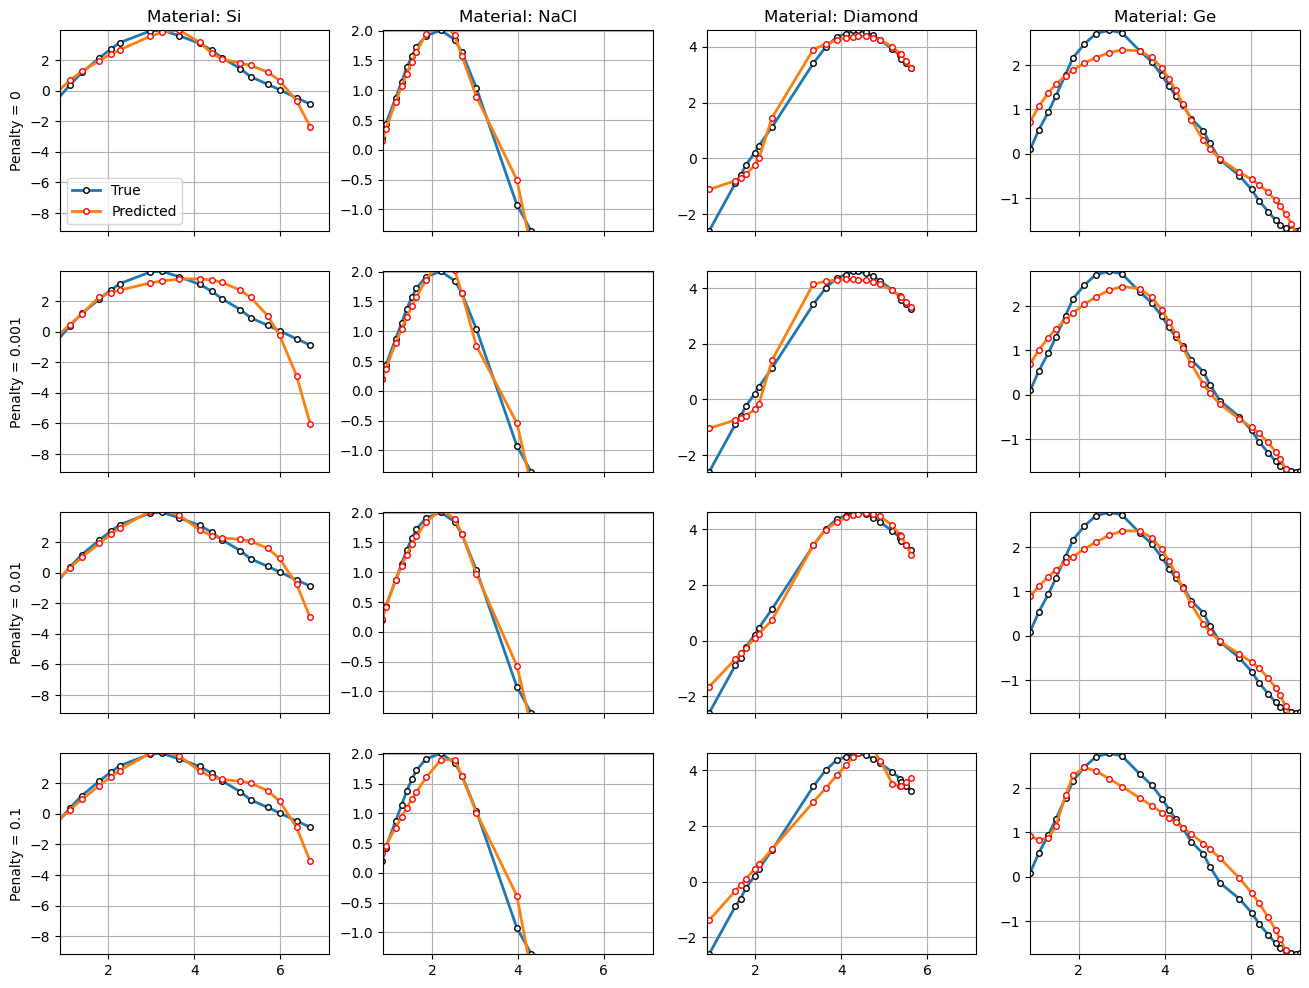

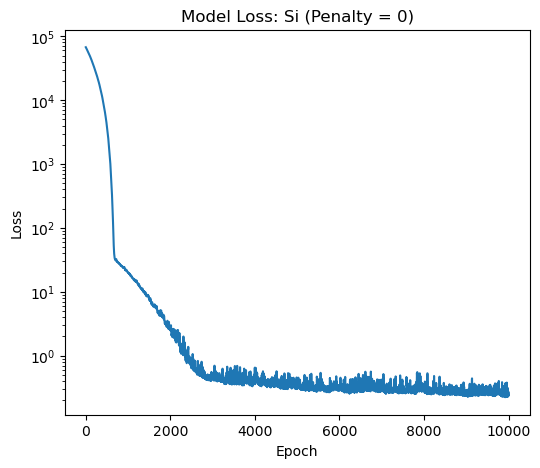

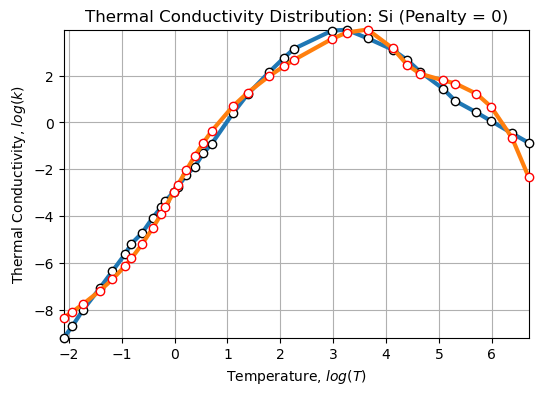

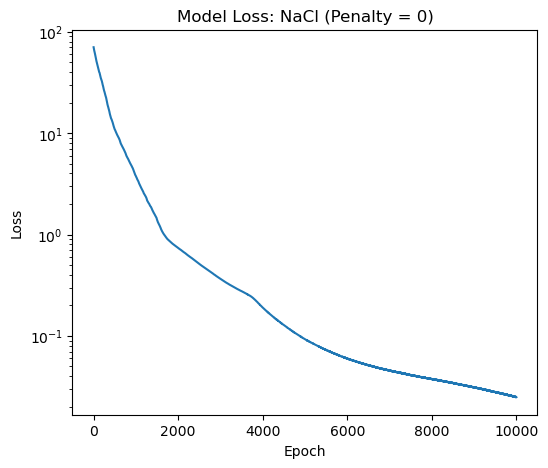

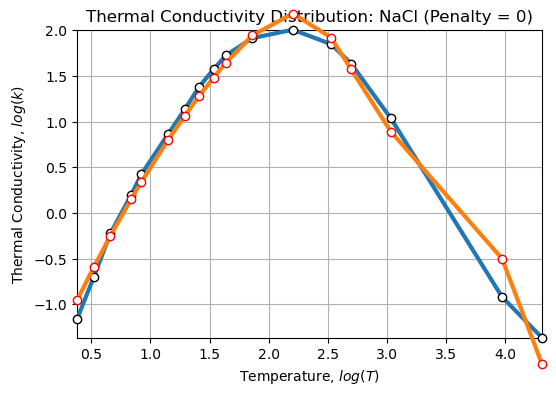

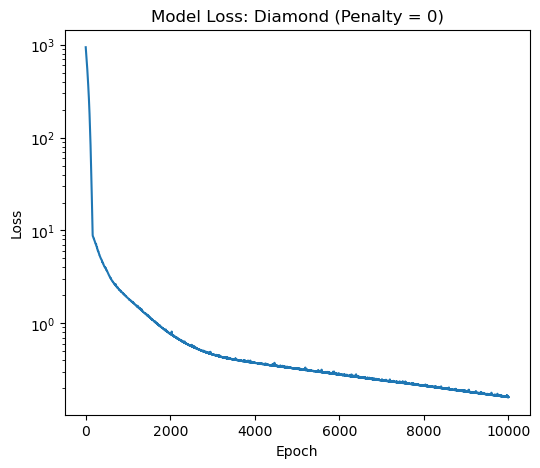

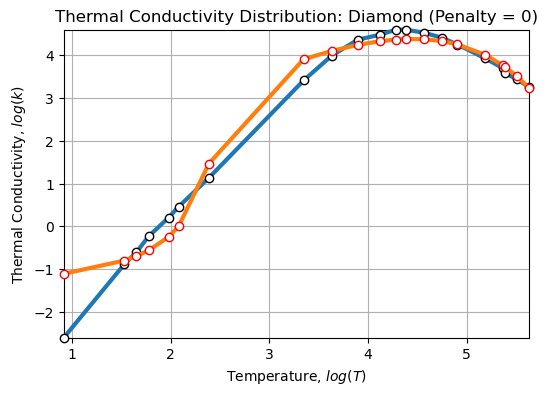

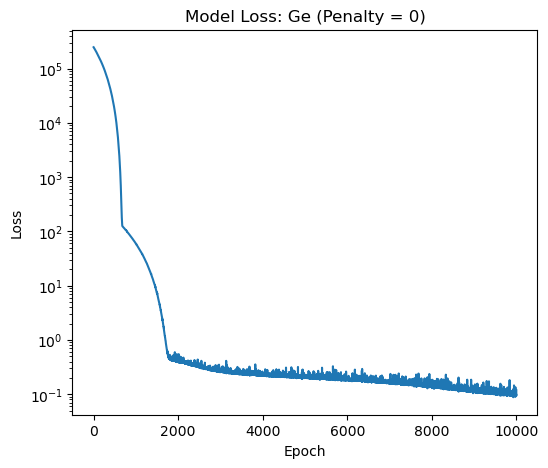

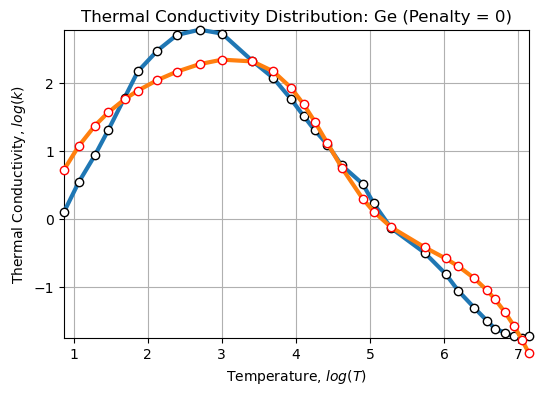

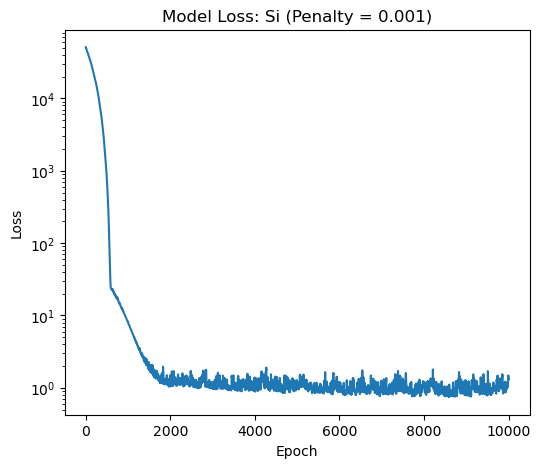

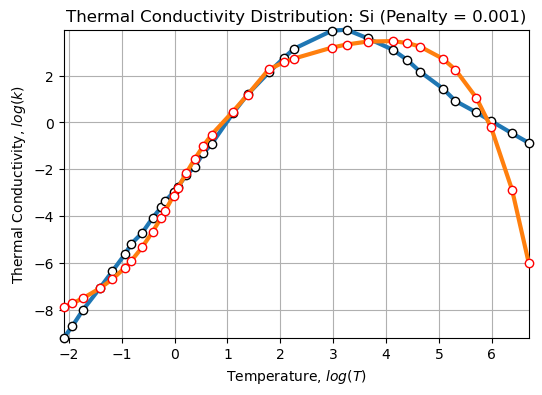

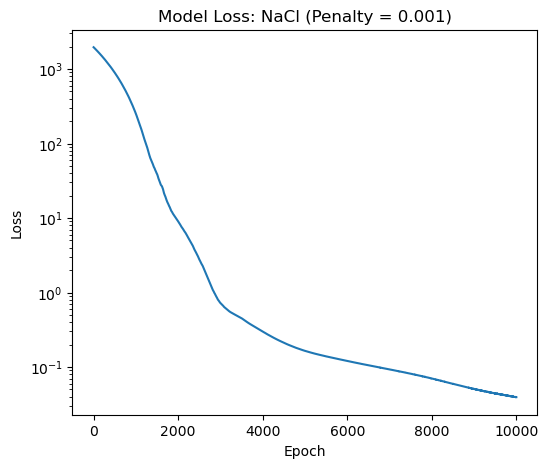

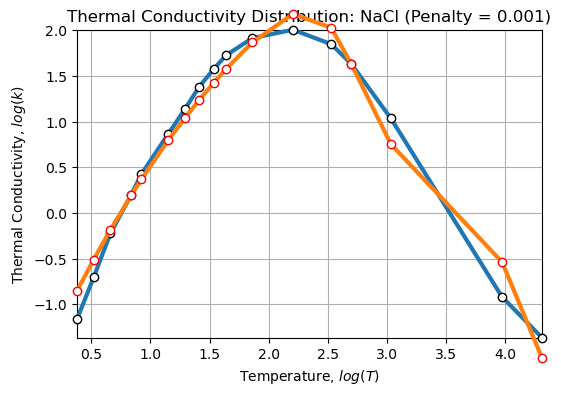

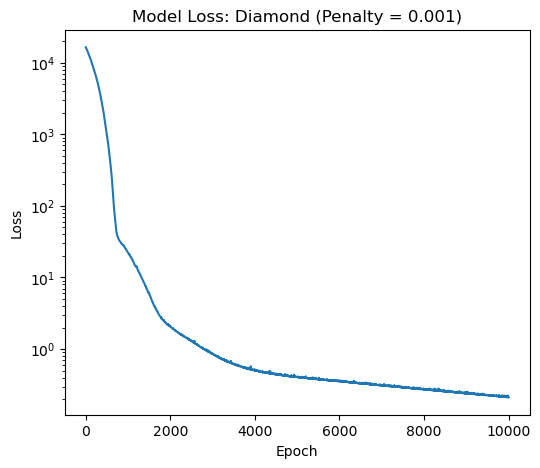

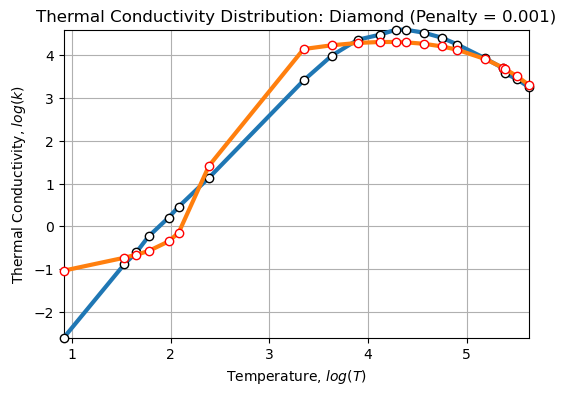

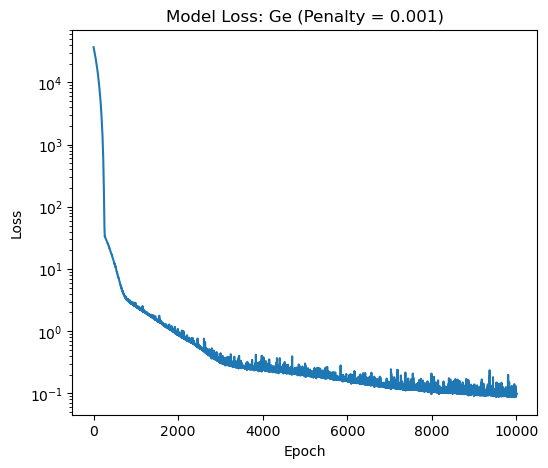

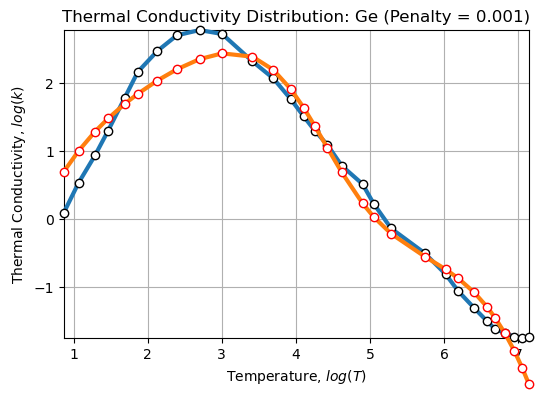

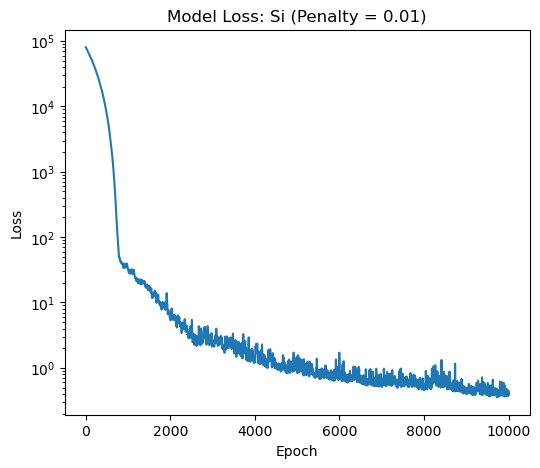

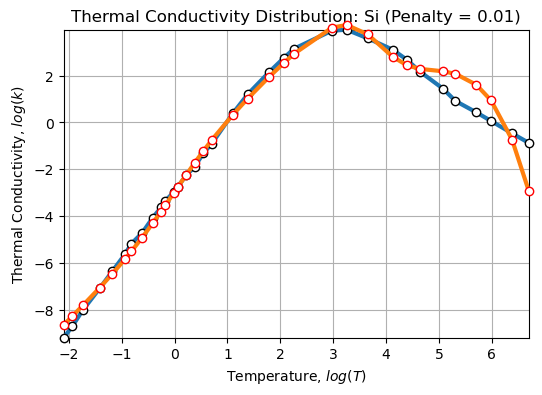

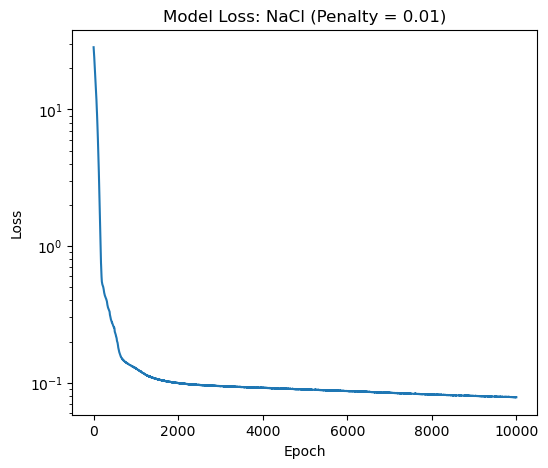

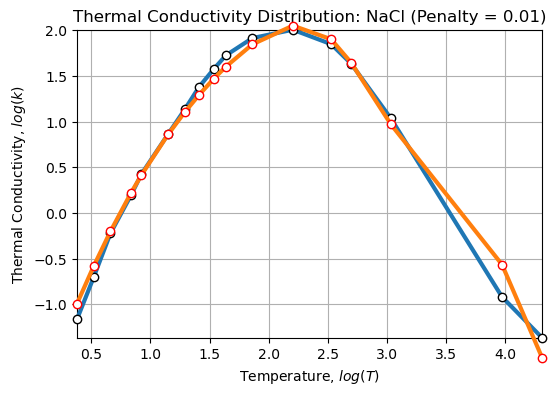

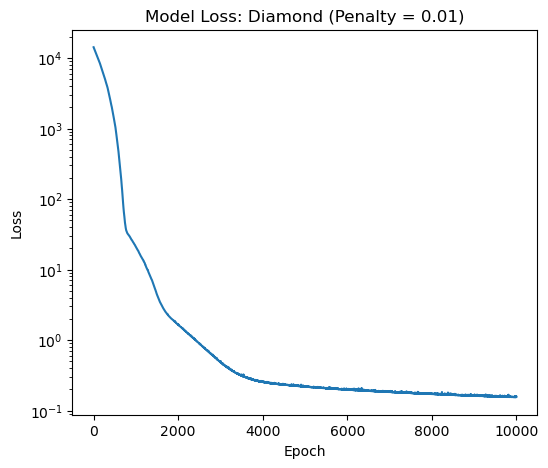

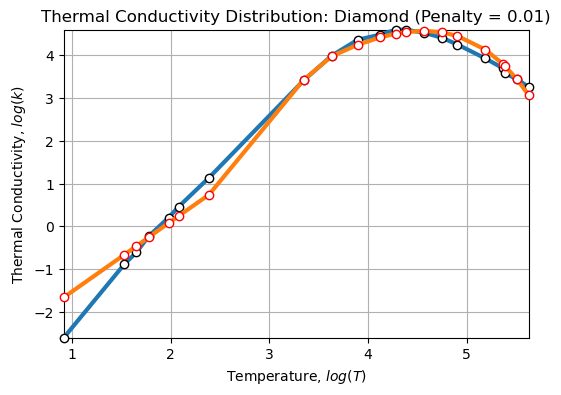

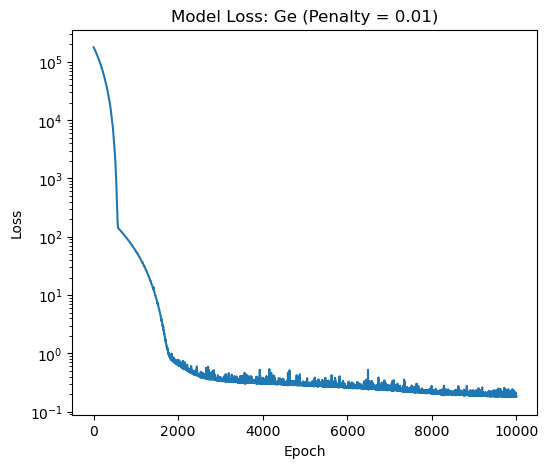

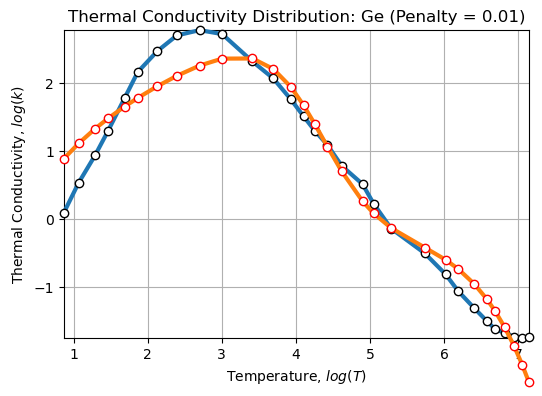

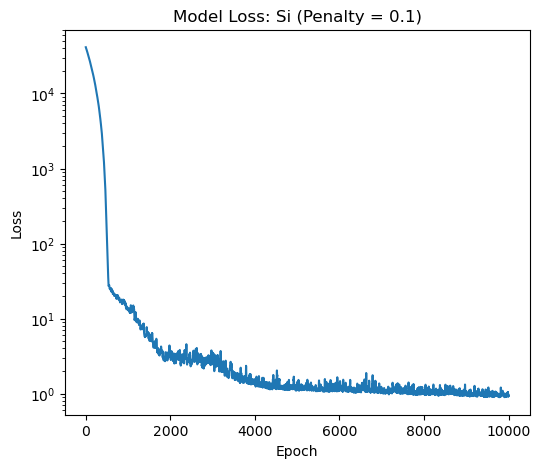

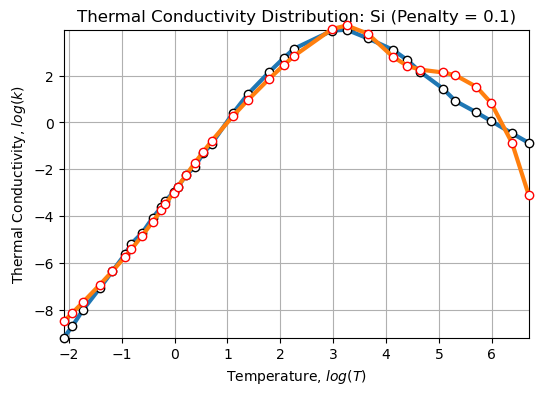

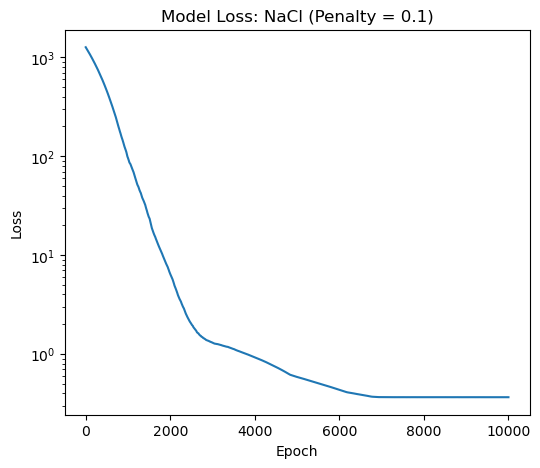

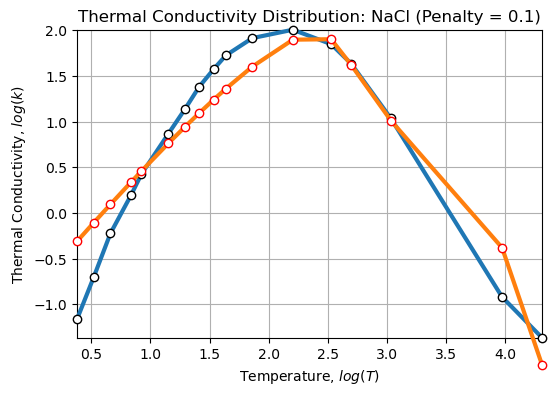

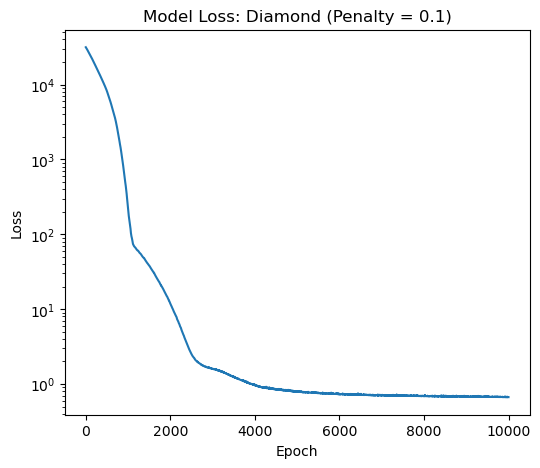

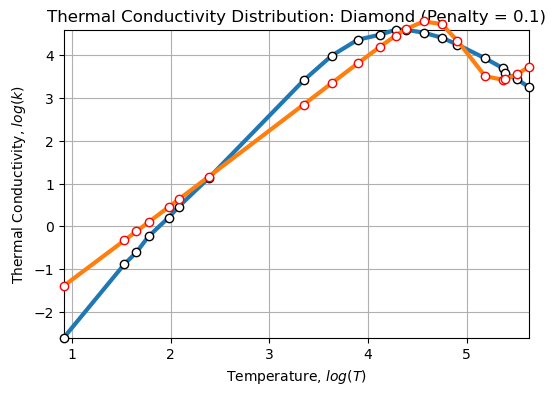

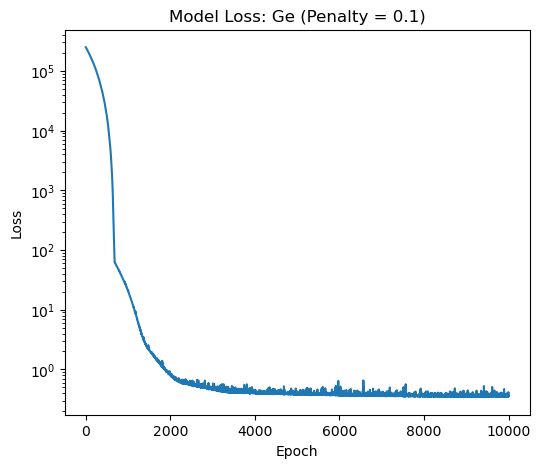

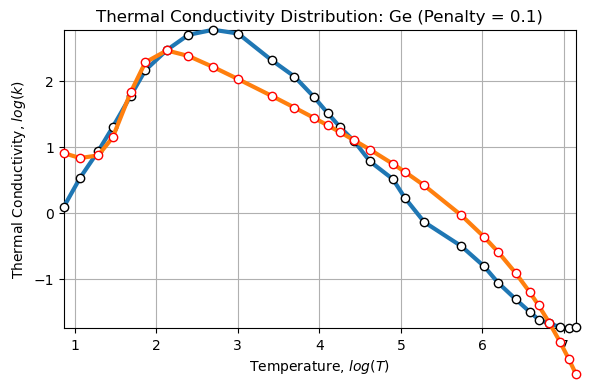

In [ ]:
model_data = {}

num_rows = len(penalties)
num_cols = len(materials)

# Create figure for grid of plots
fig_grid, axes_grid = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows), sharex=True, sharey=False)

# Step 1: Store min/max values for each material
material_limits = {}

for material in materials:
    all_logT = []
    all_logk = []

    for penalty in penalties:
        T, k = getData(material)
        logT = np.log(np.array(T))
        logk = np.log(np.array(k))

        all_logT.extend(logT)
        all_logk.extend(logk)

    # Store limits for this material
    material_limits[material] = {
        "xlim": (min(all_logT), max(all_logT)),
        "ylim": (min(all_logk), max(all_logk))
    }

for pen_i, penalty in enumerate(penalties):

    for mat_i, material in enumerate(materials):

        # Initialized File Directories
        path2saveResults = os.path.join(path2saveResults_0, material)
        path2saveResults_check = os.path.join(path2saveResults, 'Checkpoints')
        makeDIR(path2saveResults)
        makeDIR(path2saveResults_check)

        # Loading/Transforming Data
        T, k = getData(material)
        logT = np.log(np.array(T))
        logk = np.log(np.array(k))

        # Loading Model
        model = ThermalConductivityCANN(penalty)
        Save_path = path2saveResults + '/model.h5'
        Save_weights = path2saveResults + '/weights.h5'
        path_checkpoint = path2saveResults_check + '/best_weights.h5'

        plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
        Image('model_architecture.png')

        # Model Fitting
        model, history = Compile_and_fit(model, logT, logk, epochs, path_checkpoint)
        model.save(Save_path)
        with custom_object_scope({'SmoothHeaviside': SmoothHeaviside}):
            model = tf.keras.models.load_model(Save_path)
        model.save_weights(Save_weights, overwrite=True)

        # Loss Plotting
        loss_history = history.history['loss']
        fig_loss, ax_loss = plt.subplots(figsize=[6, 5])
        ax_loss.plot(loss_history)
        ax_loss.set_yscale('log')
        plt.title('Model Loss: ' + material + ' (Penalty = ' + str(penalty) + ')')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.savefig(path2saveResults + '/Plot_loss_' + material + '.pdf')
        fig_loss.show()

        logk_pred = model.predict(logT, verbose=0)

        fig_ind, ax_ind = plt.subplots(figsize=(6, 4))
        ax_ind.set_xlabel('Temperature, $log(T)$')
        ax_ind.set_ylabel('Thermal Conductivity, $log(k)$')
        ax_ind.set_title('Thermal Conductivity Distribution: ' + material + ' (Penalty = ' + str(penalty) + ')')
        ax_ind.grid(True)
        ax_ind.plot(logT, logk, marker='o', markersize=6, zorder=103, lw=3, markerfacecolor='w', markeredgecolor='k', clip_on=False)
        ax_ind.plot(logT, logk_pred, marker='o', markersize=6, zorder=103, lw=3, markerfacecolor='w', markeredgecolor='r', clip_on=False)

        # Apply consistent x and y limits per material
        ax_ind.set_xlim(material_limits[material]["xlim"])
        ax_ind.set_ylim(material_limits[material]["ylim"])
        fig_ind.show()

        ax = axes_grid[pen_i, mat_i] if num_rows > 1 and num_cols > 1 else axes_grid[max(pen_i, mat_i)]
        ax.plot(logT, logk, marker='o', markersize=4, lw=2, label="True", markerfacecolor='w', markeredgecolor='k')
        ax.plot(logT, logk_pred, marker='o', markersize=4, lw=2, label="Predicted", markerfacecolor='w', markeredgecolor='r')

        # Apply consistent x and y limits per material
        ax.set_xlim(material_limits[material]["xlim"])
        ax.set_ylim(material_limits[material]["ylim"])

        if pen_i == 0:
            ax.set_title(f"Material: {material}")
        if mat_i == 0:
            ax.set_ylabel(f"Penalty = {penalty}")

        ax.grid(True)

        model_weights_all = model.get_weights()
        w_1_1 = model_weights_all[0][0]
        w_1_2 = model_weights_all[1][0]
        w_2_weights = [w[0][0] for w in model_weights_all[2:]]
        numterms = len(w_2_weights)

        R2 = r2_score(logk.flatten(), logk_pred.flatten())

        column_label = f"{material}, {penalty}"
        model_data[column_label] = [w_1_1, w_1_2] + w_2_weights + [R2]

        print(w_1_1)
        print(w_1_2)
        print(w_2_weights)
        print(material, ': R^2 = ', R2, ' and Penalty = ', penalty)

        Config = {"Material": material, 'Penalty': penalty, "R2": R2, "weights": model_weights_all[-1].flatten().tolist()}
        json.dump(Config, open(path2saveResults + "/Config_file.txt", 'w'))

axes_grid[0, 0].legend()
plt.tight_layout()
fig_grid.show()

row_labels = ["w_1,1", "w_1,2"] + [f"w_2,{i+1}" for i in range(len(w_2_weights))] + ["r^2"]
df = pd.DataFrame(model_data, index=row_labels)

In [ ]:
df.to_csv("weights_and_r2.csv", index=False)